In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tabulate as tb
import seaborn as sns

In [35]:
df = pd.read_csv('./../res/model1_testing_1.csv')
print(tb.tabulate(df.tail(), headers='keys', tablefmt='psql'))  

+-----+------------------------+---------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+--------------+----------------------------+------------+------------+-------------+-----------+-----------+-----------------------+------------------+
|     | file_path              |   feature_set_index | features                                                                                                                                                                                                                                                                                                                                              |   repetition | first_prediction_correct   |   accur

In [36]:
def calc_precision_recall_ba(row):
    confusion_matrix = np.array(eval(row['confusion_matrix']))
    tn, fp, fn, tp = confusion_matrix.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0 
    tnr = tn / (tn + fp) if (tn + fp) > 0 else 0
    ba = (recall + tnr) / 2
    return precision, recall, ba

df['precision'] = 0.0
df['recall'] = 0.0
df['balanced_accuracy'] = 0.0
for index, row in df.iterrows():
    precision, recall, ba = calc_precision_recall_ba(row)
    df.at[index, 'precision'] = precision
    df.at[index, 'recall'] = recall
    df.at[index, 'balanced_accuracy'] = ba
    
print(tb.tabulate(df.head(), headers='keys', tablefmt='psql'))
    

+----+-----------------------+---------------------+---------------------------------------------------------------+--------------+----------------------------+------------+------------+-------------+----------+-----------+------------------------+------------------+---------------------+
|    | file_path             |   feature_set_index | features                                                      |   repetition | first_prediction_correct   |   accuracy |   f1_score |   precision |   recall |   auc_roc | confusion_matrix       |   last epoch num |   balanced_accuracy |
|----+-----------------------+---------------------+---------------------------------------------------------------+--------------+----------------------------+------------+------------+-------------+----------+-----------+------------------------+------------------+---------------------|
|  0 | ./../data/AAPL_1h.csv |                   0 | ['Close']                                                     |            0 

# PER INDEX

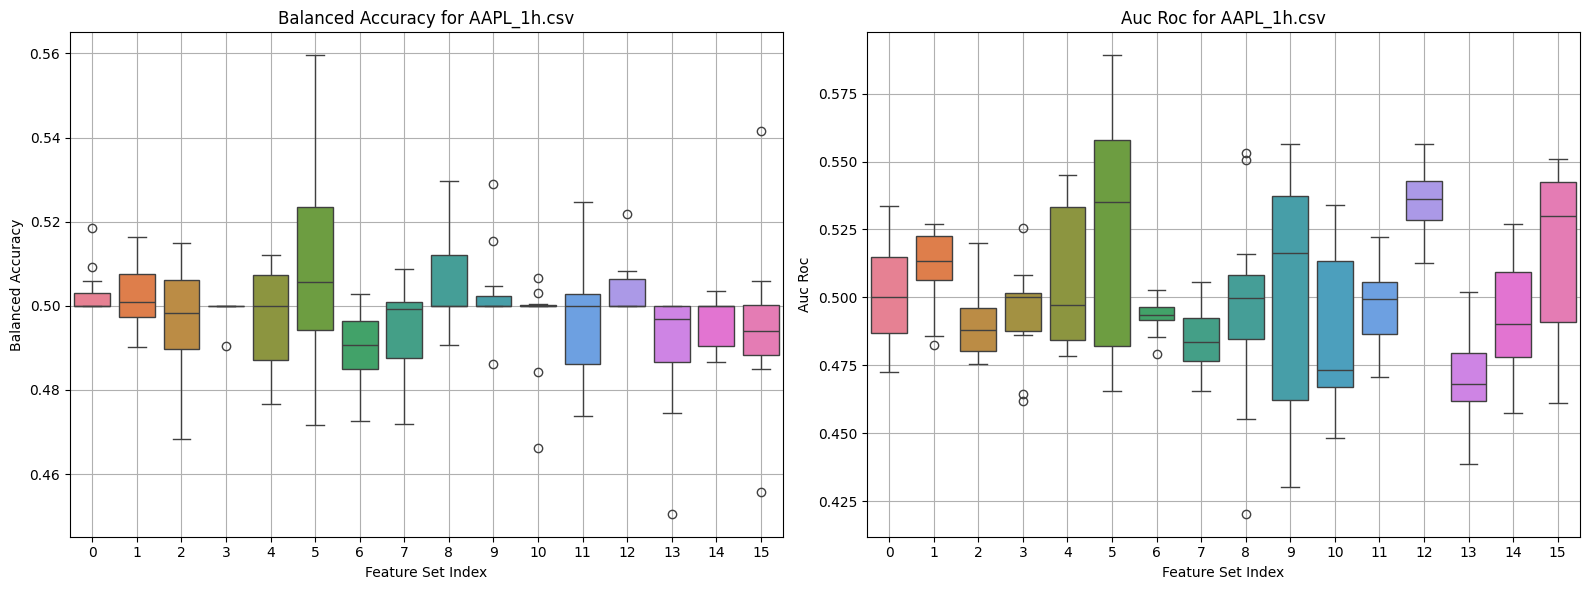

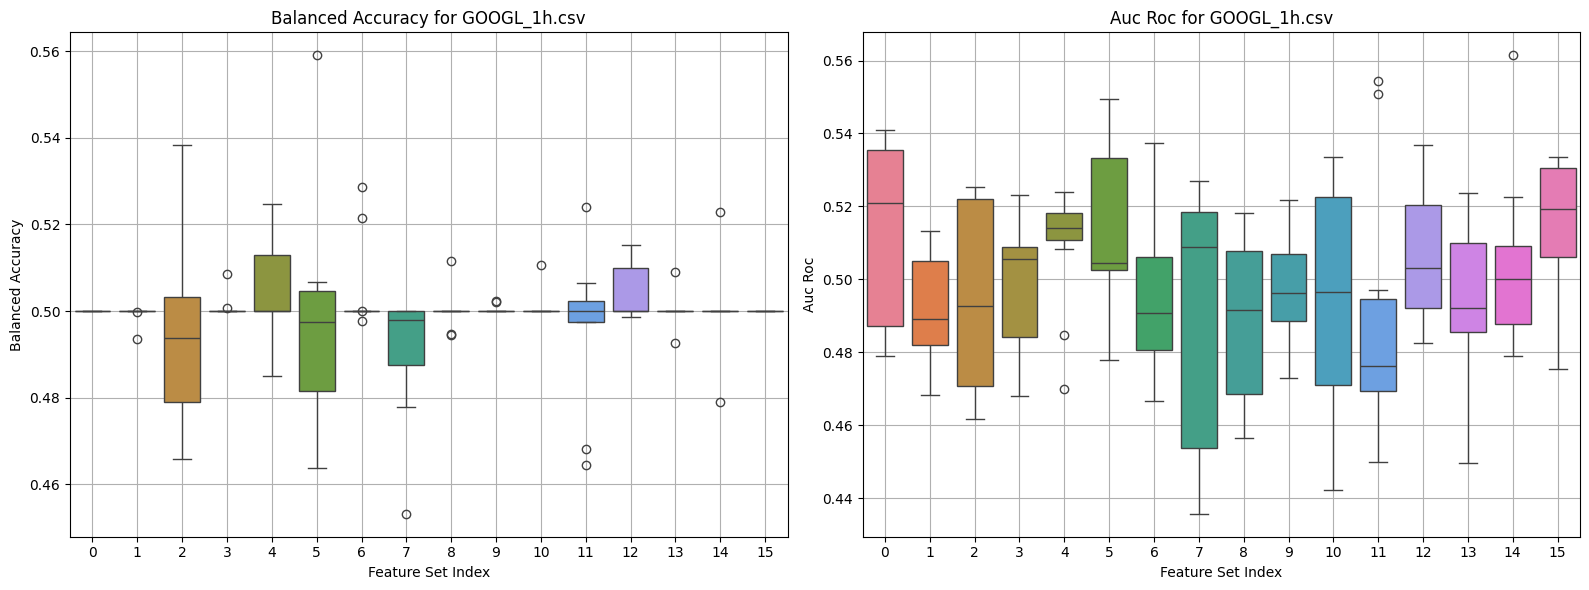

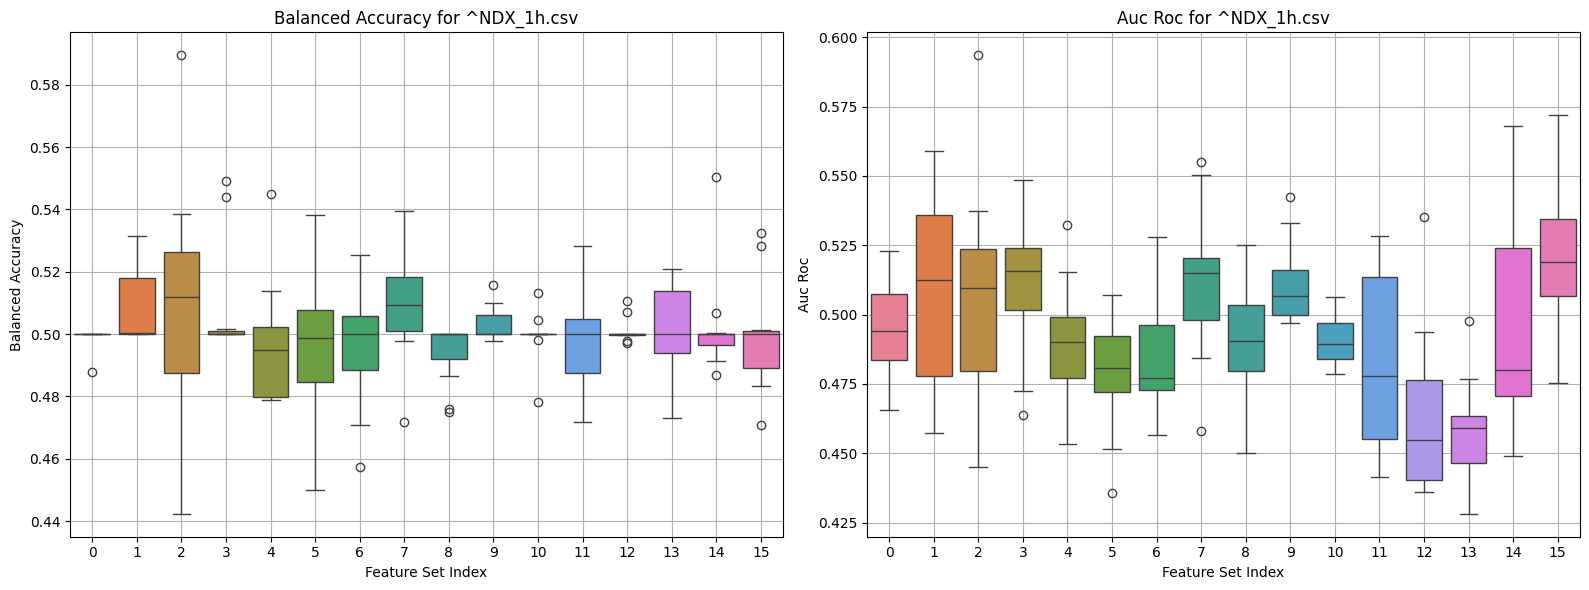

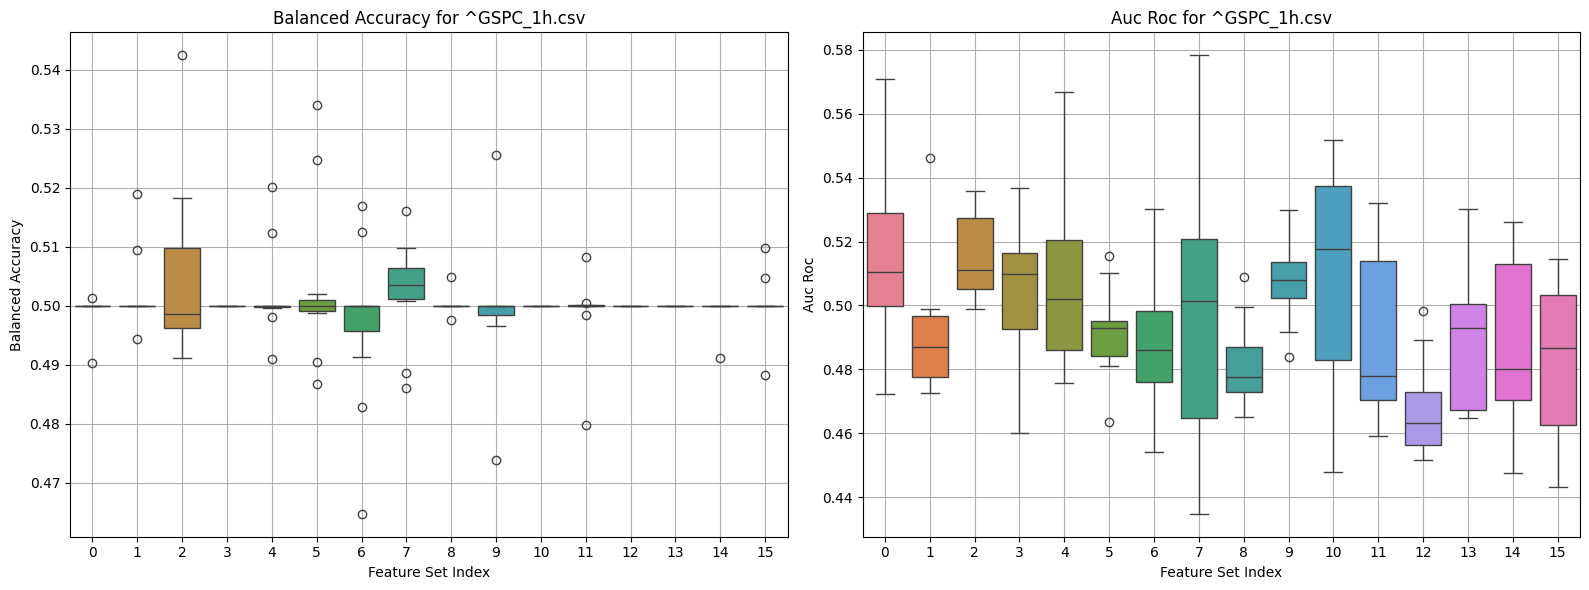

In [37]:
metrics_left = ["balanced_accuracy"] 
metrics_right = ["auc_roc"]
files = df['file_path'].unique()

for file in files:
    file_name = file.split('/')[-1]
    df_file = df[df['file_path'] == file]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    metric = metrics_left[0] 
    sns.boxplot(
        x='feature_set_index',
        y=metric,
        hue='features',
        data=df_file,
        ax=axes[0]
    )
    axes[0].set_title(f'{metric.replace("_", " ").title()} for {file_name}')
    axes[0].set_xlabel('Feature Set Index')
    axes[0].set_ylabel(metric.replace('_', ' ').title())
    if axes[0].get_legend() is not None:
        axes[0].get_legend().remove()
    axes[0].grid(True)

    metric = metrics_right[0]
    sns.boxplot(
        x='feature_set_index',
        y=metric,
        hue='features',
        data=df_file,
        ax=axes[1]
    )
    axes[1].set_title(f'{metric.replace("_", " ").title()} for {file_name}')
    axes[1].set_xlabel('Feature Set Index')
    axes[1].set_ylabel(metric.replace('_', ' ').title())
    if axes[1].get_legend() is not None:
        axes[1].get_legend().remove()
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()


# SUMMARY ACCURACY AND AUC ROC PER INDEX

In [38]:
for file in files:
    file_name = file.split('/')[-1]
    df_file = df[df['file_path'] == file]
    df_grouped = df_file.groupby(['feature_set_index']).agg(
        auc_roc=('auc_roc', 'mean'),
        b_accuracy=('balanced_accuracy', 'mean'),
        avg_last_epoch_num=('last epoch num', 'mean'),
        features_col=('features', 'first'),
    ).sort_values(by='auc_roc', ascending=False).reset_index() 
    print(f'\nSummary for file: {file_name}')
    print(tb.tabulate(df_grouped, headers='keys', tablefmt='psql'))


Summary for file: AAPL_1h.csv
+----+---------------------+-----------+--------------+----------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    |   feature_set_index |   auc_roc |   b_accuracy |   avg_last_epoch_num | features_col                                                                                                                                                                                                                                                                                                                                          |
|----+---------------------+-----------+--------------+----------------------+---------------------------------------------

# RESULTS AGG

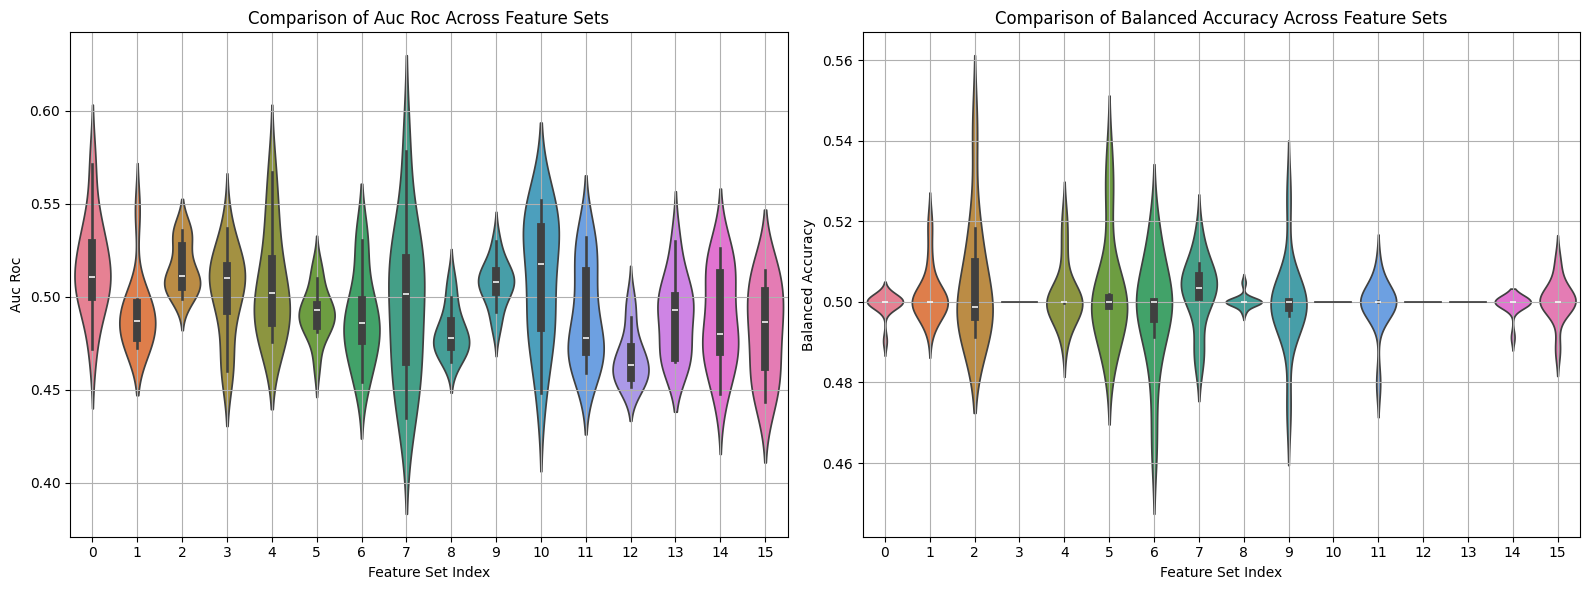

In [39]:
metrics = ["auc_roc", "balanced_accuracy"]

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for ax, metric in zip(axes, metrics):
    sns.violinplot(
        x='feature_set_index',
        y=metric,
        hue='features',
        data=df_file,
        ax=ax
    )
    ax.set_title(f'Comparison of {metric.replace("_", " ").title()} Across Feature Sets')
    ax.set_xlabel('Feature Set Index')
    ax.set_ylabel(metric.replace('_', ' ').title())

    # Remove duplicate legend inside each subplot
    if ax.get_legend() is not None:
        ax.get_legend().remove()

    ax.grid(True)

plt.tight_layout()
plt.show()


In [42]:
#calc rankings for features sets by each file
df['auc_roc_rank'] = df.groupby('file_path')['auc_roc'].rank(ascending=False, method='min')
df['accuracy_rank'] = df.groupby('file_path')['balanced_accuracy'].rank(ascending=False,method='min')
df['combined_rank'] = df['auc_roc_rank'] + df['accuracy_rank']
df_ranked = df.groupby('feature_set_index').agg(
    combined_rank=('combined_rank', 'sum'),
    auc_roc=('auc_roc', 'mean'),
    b_accuracy=('balanced_accuracy', 'mean'),
    features_col=('features', 'first'),
).sort_values(by='combined_rank').reset_index()

print('\nOverall Feature Set Rankings:')
print(tb.tabulate(df_ranked, headers='keys', tablefmt='psql'))


Overall Feature Set Rankings:
+----+---------------------+-----------------+-----------+--------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|    |   feature_set_index |   combined_rank |   auc_roc |   b_accuracy | features_col                                                                                                                                                                                                                                                                                                                                          |
|----+---------------------+-----------------+-----------+--------------+------------------------------------------------------------

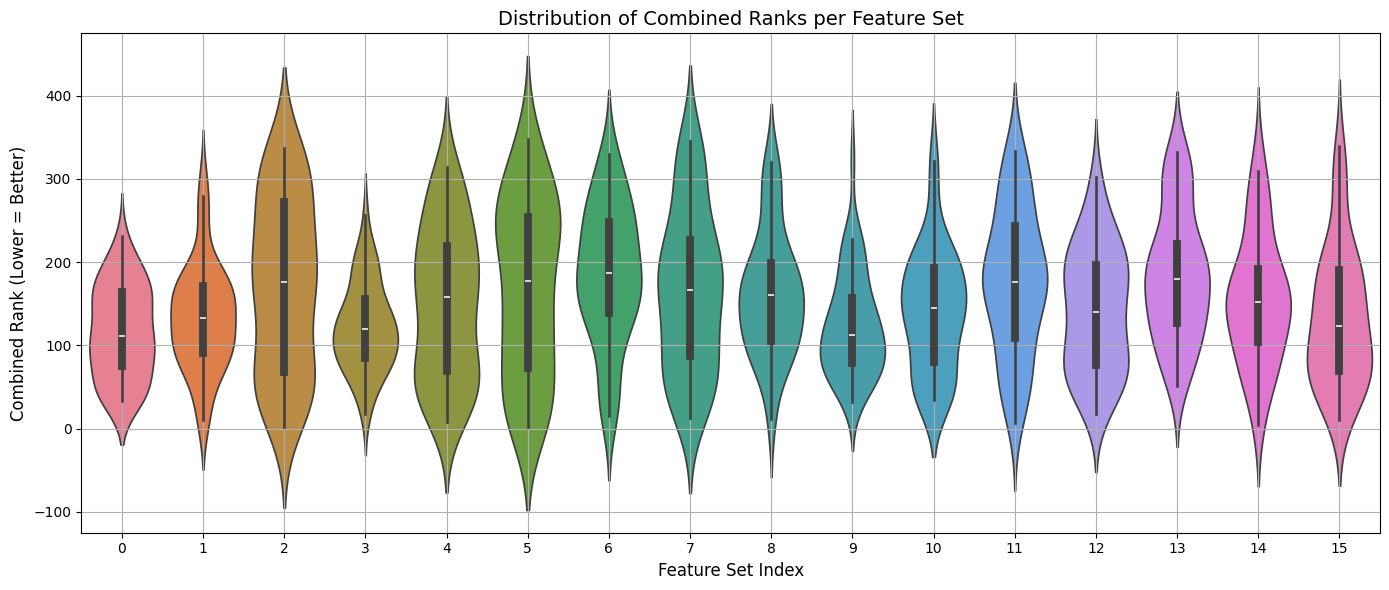

+-----+---------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|     |   feature_set_index | features                                                                                                                                                                                                                                                                                                                                              |
|-----+---------------------+-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [41]:
plt.figure(figsize=(14, 6))
ax = sns.violinplot(x='feature_set_index', y='combined_rank', hue='features', data=df)


plt.title("Distribution of Combined Ranks per Feature Set", fontsize=14)
plt.xlabel("Feature Set Index", fontsize=12)
plt.ylabel("Combined Rank (Lower = Better)", fontsize=12)
if ax.get_legend() is not None:
    ax.get_legend().remove()
plt.tight_layout()
plt.grid(True)
plt.show()

print(tb.tabulate(df[['feature_set_index', 'features']].drop_duplicates().sort_values('feature_set_index'), headers='keys', tablefmt='psql'))